In [2]:
import torchvision
import torchvision.transforms as transforms
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [41]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

Files already downloaded


In [42]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

In [43]:
classes = ('Zero', 'One', 'Two', 'Three',
           'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine')

In [44]:
trainset.train_data.size()

torch.Size([60000, 28, 28])

In [45]:
trainset.train_labels.size()

torch.Size([60000])

In [46]:
dataiter = iter(trainloader)

In [47]:
images, labels = dataiter.next()

In [48]:
images.size()

torch.Size([4, 1, 28, 28])

In [49]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

    0     5     6     3


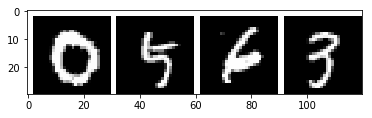

In [50]:
# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%labels[j] for j in range(4)))

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*4*4, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.cuda()

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (256 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

In [52]:
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [56]:
for epoch in range(2): # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
               
        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
               
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()        
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 0.361
[1,  4000] loss: 0.142
[1,  6000] loss: 0.118
[1,  8000] loss: 0.107
[1, 10000] loss: 0.094
[1, 12000] loss: 0.074
[1, 14000] loss: 0.080
[2,  2000] loss: 0.061
[2,  4000] loss: 0.059
[2,  6000] loss: 0.060
[2,  8000] loss: 0.074
[2, 10000] loss: 0.072
[2, 12000] loss: 0.071
[2, 14000] loss: 0.060
Finished Training


In [57]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                          shuffle=False, num_workers=2)

Files already downloaded


('GroundTruth: ', 'Seven   Two   One  Zero')


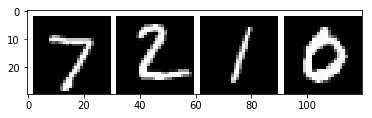

In [58]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [59]:
outputs = net(Variable(images.cuda()))

# the outputs are energies for the 10 classes. 
# Higher the energy for a class, the more the network 
# thinks that the image is of the particular class

# So, let's get the index of the highest energy
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s'% classes[predicted[j][0]] for j in range(4)))

('Predicted: ', 'Seven   Two   One  Zero')


In [62]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [64]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels.cuda()).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

In [65]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  Zero : 99 %
Accuracy of   One : 98 %
Accuracy of   Two : 97 %
Accuracy of Three : 98 %
Accuracy of  Four : 98 %
Accuracy of  Five : 99 %
Accuracy of   Six : 98 %
Accuracy of Seven : 96 %
Accuracy of Eight : 98 %
Accuracy of  Nine : 97 %
